In [55]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import layers, models, optimizers
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import interp1d

In [2]:
def nanscaler(seri):
    temp_list = []
    series_mean = seri.mean()
    series_std = seri.std()
    for i in seri:
        if np.isnan(i):
            temp_list.append(0)
        else :
            temp_list.append((i - series_mean)/series_std)
    return series_mean, series_std, temp_list 

def nanscaler_test(s_mean,s_std,seri):
    temp_list = []
    for i in seri:
        if np.isnan(i):
            temp_list.append(0)
        else :
            temp_list.append((i - s_mean)/s_std)
    return temp_list

In [97]:
df = pd.read_csv('trainMerged.csv')
test_df = pd.read_csv('testMerged.csv')
df['Date'] = pd.to_datetime(df.Date)
test_df['Date'] = pd.to_datetime(test_df.Date)
df['IsHoliday'] = df.IsHoliday.astype('int')
test_df['IsHoliday'] = test_df.IsHoliday.astype('int')
MarkDowns = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for i in MarkDowns:
    s_mean,s_std, df[i] = nanscaler(df[i])
    test_df[i] = nanscaler_test(s_mean,s_std,test_df[i])

In [98]:
df['Day_of_year'] = [i.dayofyear for i in df.Date]
test_df['Day_of_year'] = [i.dayofyear for i in test_df.Date]
df['Year'] = [i.year for i in df.Date]

In [99]:
doy = []
for i,d in enumerate(df.Day_of_year):
    j = d
    if df['Year'][i] == 2012:
        if d > 60:
            j -= 1
    doy.append(j)
df['Day_of_year'] = doy
df.drop(['Year'],axis=1,inplace=True)
tempp = test_df.Date - pd.to_datetime('2010-01-01')
test_df['total_days'] = [i.total_seconds()/86400 for i in tempp]
tempp = df.Date - pd.to_datetime('2010-01-01')
df['total_days'] = [i.total_seconds()/86400 for i in tempp]
test_df['CPI'] = test_df.groupby('Store')['CPI'].transform(lambda x : x.fillna(x.mean()))
test_df['Unemployment'] = test_df.groupby('Store')['Unemployment'].transform(lambda x : x.fillna(x.mean()))

In [100]:
zero_1_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))


In [101]:
#['Store', 'Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Type', 'Size',
#'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
#'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Day_of_year']
num_cols = ['Size', 'Temperature', 'Fuel_Price','CPI' ,'Unemployment','Day_of_year']
num_df = df[num_cols]
num_df_test = test_df[num_cols]
cat_df = pd.get_dummies(df[['Store','Dept','Type']].astype('str'))
cat_df_test = pd.get_dummies(test_df[['Store','Dept','Type']].astype('str'))
zero_1_scaler.fit(num_df)
num_df = pd.DataFrame(zero_1_scaler.transform(num_df),columns=num_df.columns)
num_df_test = pd.DataFrame(zero_1_scaler.transform(num_df_test),columns=num_df_test.columns)

In [102]:
df_1 = pd.concat([num_df,cat_df,df['Dept'],df['Weekly_Sales']],axis= 1)
test_1 = pd.concat([num_df_test,cat_df_test,test_df['Dept']], axis=1)
test_1['Day_of_year'][test_1.Day_of_year< 0] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [103]:
aa = df_1.groupby('Dept')

In [104]:
grp_dep_doy = dict()
for i, j in aa:
    grp_dep_doy[i] = j.groupby('Day_of_year')['Weekly_Sales'].mean()
grp_dep_doy = pd.DataFrame(grp_dep_doy)
grp_dep_doy.sort_index(inplace=True)
grp_dep_doy.fillna(0 ,inplace= True)

In [105]:
def get_sales_mean(doy, dep):
    f = interp1d(grp_dep_doy.index, grp_dep_doy[dep])
    return f(doy)

In [106]:
tes_mean_sales = []
for dep, doy in zip(test_1.Dept, test_1.Day_of_year):
    tes_mean_sales.append(get_sales_mean(doy,dep))

In [107]:
test_1['Mean_Sales'] = tes_mean_sales
test_1['Mean_Sales'].isnull().sum()

0

In [108]:
tr_mean_sales = []
for dep, doy in zip(df_1.Dept, df_1.Day_of_year):
    tr_mean_sales.append(grp_dep_doy[dep][doy])
df_1['Mean_Sales'] = tr_mean_sales

In [114]:
print(df_1.columns[:70])
print(df_1.columns[70:])
# df_1 = df_1[['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
#        'Day_of_year', 'Store_1', 'Store_10', 'Store_11', 'Store_12',
#        'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18',
#        'Store_19', 'Store_2', 'Store_20', 'Store_21', 'Store_22', 'Store_23',
#        'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28', 'Store_29',
#        'Store_3', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34',
#        'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_4',
#        'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
#        'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Type_A',
#        'Type_B', 'Type_C','Mean_Sales', 'Dept', 'Weekly_Sales'
#        ]]
# test_1 = test_1[['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
#        'Day_of_year', 'Store_1', 'Store_10', 'Store_11', 'Store_12',
#        'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18',
#        'Store_19', 'Store_2', 'Store_20', 'Store_21', 'Store_22', 'Store_23',
#        'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28', 'Store_29',
#        'Store_3', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34',
#        'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_4',
#        'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
#        'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Type_A',
#        'Type_B', 'Type_C','Mean_Sales', 'Dept',
#        ]]

Index(['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'Day_of_year', 'Store_1', 'Store_10', 'Store_11', 'Store_12',
       'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18',
       'Store_19', 'Store_2', 'Store_20', 'Store_21', 'Store_22', 'Store_23',
       'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28', 'Store_29',
       'Store_3', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34',
       'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_4',
       'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
       'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Dept_1',
       'Dept_10', 'Dept_11', 'Dept_12', 'Dept_13', 'Dept_14', 'Dept_16',
       'Dept_17', 'Dept_18', 'Dept_19', 'Dept_2', 'Dept_20', 'Dept_21',
       'Dept_22', 'Dept_23', 'Dept_24', 'Dept_25', 'Dept_26', 'Dept_27'],
      dtype='object')
Index(['Dept_28', 'Dept_29', 'Dept_3', 'Dept_30', 'Dept_31', 'Dept_32',
       '

In [9]:
# aa1 = df_1.values
# np.random.shuffle(aa1)
# tr_1 = aa1[:400000,:-1]
# lbl_1 = aa1[:400000,-1]
# val_1 = aa1[400000:,:-1]
# val_lbl_1 = aa1[400000:,-1]
aa = df_1.groupby('Dept')
bb = test_1.groupby('Dept')
departments = df.Dept.unique()
X_train = dict()
X_test = dict()
X_val = dict()
y_train = dict()
y_val = dict()
# for dep in departments:
#     gr_df = aa.get_group(dep).values
#     np.random.shuffle(inds)
    

In [9]:
aa.get_group(1).shape

(6435, 56)

In [10]:
ffd = aa.get_group(1).values
np.random.shuffle(ffd)
X_tr = ffd[:,:-2]
y_tr = ffd[:,-1]
X_v = ffd[-700:,:-2]
y_v = ffd[-700:,-1]

In [28]:
dep1 = aa.get_group(1)
df.Size.describe()

count    421570.000000
mean     136727.915739
std       60980.583328
min       34875.000000
25%       93638.000000
50%      140167.000000
75%      202505.000000
max      219622.000000
Name: Size, dtype: float64

In [52]:
from sklearn.model_selection import GridSearchCV
regressor = SVR()
params = {'C':[1,100,.01],'gamma':[.001,.01,1]}
gs = GridSearchCV(regressor,param_grid = params, scoring = 'neg_mean_squared_error')

In [53]:
gs.fit(X_tr,y_tr)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 100, 0.01], 'gamma': [0.001, 0.01, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [56]:
X_tr.shape

(6435, 54)

In [54]:
mean_absolute_error(y_v, gs.best_estimator_.predict(X_v))

5379.795305754263

In [ ]:
model1 = models.Sequential()
model1.add(layers.Dense(128,activation='relu',input_shape = (54,)))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(128,activation= 'relu'))
model1.add(layers.Dense(128,activation= 'relu'))
model1.add(layers.Dense(1))
model1.compile(loss='mse', optimizer='Adam', metrics=['acc'])

In [ ]:
# model1.summary()
model1.fit(X_tr,y_tr,epochs= 500, validation_split=0.1)

In [ ]:
stores = df.Store.unique()
dept_no = 7
for store_no in stores:
    bb = aa.get_group(store_no)
    bb = bb[bb.Dept==dept_no]
    bb.index = range(len(bb))
    bb = np.split(bb, bb[bb.round_days.diff()<0].index, axis = 0)
    for i in bb:
        plt.plot(i.round_days,i.Weekly_Sales/(i.Weekly_Sales.mean()))

In [40]:
aa.colum

AttributeError: Cannot access attribute 'index' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [29]:
mean_sale

Day_of_year
0.000000    13180.086889
0.002786    11628.317333
0.019499    13624.038000
0.022284    12730.946000
0.038997    14669.180444
0.041783    13864.207111
0.058496    15126.391778
0.061281    14499.738000
0.077994    18216.596444
0.080780    17613.400667
0.083565    19596.298000
0.097493    25121.113333
0.100279    26941.714444
0.103064    32381.831111
0.116992    39540.355778
0.119777    32470.996444
0.122563    24850.163556
0.136490    15634.010667
0.139276    13765.470444
0.142061    15142.035111
0.153203    17540.764222
0.158774    15201.214222
0.161560    16947.834889
0.172702    17567.973111
0.178273    15638.433111
0.181058    17864.154000
0.192201    18882.558222
0.197772    16074.316444
0.200557    18815.254889
0.211699    20093.242000
                ...     
0.757660    19008.062889
0.763231    19210.683778
0.766017    19767.443111
0.777159    20815.728444
0.782730    20563.906889
0.785515    21815.235333
0.796657    23048.499111
0.802228    23839.922222
0.805014    2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


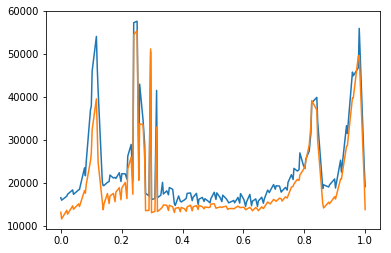